## This file contains the code that carries the ingredients recommendation for a **single** SCENT

Installing libraries

In [1]:
!pip install rdkit-pypi
 # # Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

!pip install pytorch-ignite
!pip install autotune
!pip install ray[default]
!pip install tensorboardX
!pip install cirpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-pyt

Changing directory

In [2]:
import os
path = "/content/drive/MyDrive/Colab Notebooks/Projeto_Sandris"
os.chdir(path)

Preprocessing - reading to a dataframe, converting CAS number to lists

In [3]:
import utils
import ast


#Importing file
scent_file = "Data/smell_6.csv" #Put the file path here
df_scent = utils.read_csv_2df(scent_file)

#Filtering
df_filtered = utils.filter_zero_molfrac(df_scent)
df_filtered["CAS"] = df_filtered["CAS"].apply(lambda x: ast.literal_eval(x))
df_filtered["CAS"] = df_filtered["CAS"].apply(lambda x: x[0])

<ipython-input-3-2536a3932286>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["CAS"] = df_filtered["CAS"].apply(lambda x: ast.literal_eval(x))
<ipython-input-3-2536a3932286>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["CAS"] = df_filtered["CAS"].apply(lambda x: x[0])


Converting CAS number to smiles

In [4]:
#Obtaining smiles representation
smiles = {}
for count, row in enumerate(df_filtered.CAS):
  smile = utils.cas_to_smiles(row)
  smiles[df_filtered.Substance.iloc[count]] = smile

Converting smiles to mol

In [5]:
from rdkit import Chem
from sklearn.model_selection import train_test_split
import mol2graph
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [6]:
mols =  {key: Chem.MolFromSmiles(smiles[key]) for key in list(smiles.keys())}

Printing some ingredient

In [7]:
df_filtered["CAS"].iloc[10]

'91-64-5'

### Using AI to predict how ingredients smells like

In [8]:
graphs = [mol2graph.mol2vec(mols[m]) for m in list(mols.keys())]

/content/drive/MyDrive/Colab Notebooks/Projeto_Sandris/mol2graph.py:229: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data = Data(x=torch.tensor(node_f, dtype=torch.float),


Building AI model structure

In [9]:
#Defining neural model
n_features = graphs[0].num_node_features
class Net(torch.nn.Module):
    def __init__(self, gc, linear, dropout):
        super(Net, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(n_features, gc[0], cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(gc[0]) 
        self.conv2 = GCNConv(gc[0], gc[1], cached=False)
        self.bn2 = BatchNorm1d(gc[1])
        self.conv3 = GCNConv(gc[1], gc[2], cached=False)
        self.bn3 = BatchNorm1d(gc[2])
        self.fc1 = Linear(gc[2], linear[0])
        self.bn4 = BatchNorm1d(linear[0])
        self.fc2 = Linear(linear[0],linear[1])
        self.fc3 = Linear(linear[1], 112)
         
    def forward(self, data):
        #input
        x, edge_index = data.x, data.edge_index

        #GCN1
        x = F.selu(self.conv1(x, edge_index))

        #GCN2
        #x = self.bn1(x)
        x = F.selu(self.conv2(x, edge_index))

        #GCN3
        #x = self.bn2(x)
        x = F.selu(self.conv3(x, edge_index))

        #Pooling
        x = global_add_pool(x, data.batch)
       

        #Dense Layer 1
        x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = self.dropout, training=self.training)

        #Dense Layer 2
        x = self.bn4(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p = self.dropout, training=self.training)
        
        #Output Layer 3
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

    #copie de cima de novo
    def embbed(self, data):
        #input
        x, edge_index = data.x, data.edge_index

        #GCN1
        x = F.selu(self.conv1(x, edge_index))

        #GCN2
        #x = self.bn1(x)
        x = F.selu(self.conv2(x, edge_index))

        #GCN3
        #x = self.bn2(x)
        x = F.selu(self.conv3(x, edge_index))

        #Pooling
        x = global_add_pool(x, data.batch)
       

        #Dense Layer 1
        #x = self.bn3(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = .5, training=self.training)

        #Dense Layer 2
        x = self.bn4(x)
        x = F.relu(self.fc2(x))
        return x

In [10]:
device = "cpu"
config = {'gc1': 64, 
 'gc2': 128, 
 'gc3': 64, 
 'l1': 128, 
 'l2': 64, 
 'lr': 0.00130199,
 'dropout': 0.5, 
 'batch_size': 16}
model = Net(gc = [config['gc1'], config['gc2'], config['gc3']],
                linear = [config['l1'], config['l2']], dropout = config['dropout']).to(device)

In [11]:
PATH = 'Model/model.pt-alldata'

map_location=torch.device('cpu')

model.load_state_dict(torch.load(PATH,  map_location = map_location))

<All keys matched successfully>

In [15]:
model.conv1

GCNConv(75, 64)

In [20]:
import numpy as np
import pandas as pd
fc1_w = model.fc1.weight
fc2_w = model.fc2.weight
fc3_w = model.fc3.weight

fc1_np = fc1_w.detach().numpy()
fc2_np = fc2_w.detach().numpy()
fc3_np = fc3_w.detach().numpy()
pd.DataFrame(fc1_np).to_csv("fc1.csv")
pd.DataFrame(fc2_np).to_csv("fc2.csv")
pd.DataFrame(fc3_np).to_csv("fc3.csv")

BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
embeds = DataLoader(graphs, batch_size = len(graphs), 
                         shuffle = False)

for data in embeds:
    model.eval()
    data = data.to(device)
    output = model.embbed(data)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
np_output = output.detach().numpy()

In [ ]:
np_output.shape

(12, 64)

Reading ingredients database

In [ ]:
import pandas as pd
import cirpy

In [ ]:
ingredients_databank = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projeto_Sandris/Data/curated_ds_oh.csv", index_col = False)

In [ ]:
db_smiles = ingredients_databank.smiles

In [ ]:
mols_db = [Chem.MolFromSmiles(smile) for smile in db_smiles]

In [ ]:
graphs_db = [mol2graph.mol2vec(mol) for mol in mols_db]

In [ ]:
embeds_db = DataLoader(graphs_db, batch_size = len(graphs_db), 
                         shuffle = False)

for data in embeds_db:
    model.eval()
    data = data.to(device)
    output_db = model.embbed(data)

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
np_output_db = output_db.detach().numpy()

In [ ]:
np_output_db.shape

(2230, 64)

Making ingredient recommendation

In [ ]:
from numpy.linalg import norm

In [ ]:
scores_recommender = np.matmul(np_output_db, np_output.T)

In [ ]:
scores_recommender.shape

(2230, 12)

In [ ]:
print(np_output_db.shape, np_output.shape)

(2230, 64) (12, 64)


In [ ]:
cos_scores_recommend = np.zeros((np_output_db.shape[0], np_output.shape[0]))

for i in range(0, 2230):
    for j in range(0, np_output.shape[0]):
        cos_scores_recommend[i, j] = np.dot(np_output_db[i, :], np_output[j, :])/(norm(np_output_db[i, :])*norm(np_output[j, :]))

In [ ]:
cos_scores_recommend

array([[0.53211361, 0.48457253, 0.40084407, ..., 0.37835252, 0.52174741,
        0.21931206],
       [0.24497715, 0.26524124, 0.43722966, ..., 0.17250812, 0.30582625,
        0.37150523],
       [0.82648969, 0.8931545 , 0.53737825, ..., 0.7820887 , 0.76517928,
        0.19630261],
       ...,
       [0.62649328, 0.60884917, 0.4918749 , ..., 0.49934798, 0.84000915,
        0.15706788],
       [0.58334315, 0.54528362, 0.46074909, ..., 0.47415346, 0.80821365,
        0.21181914],
       [0.73597443, 0.69080418, 0.41907674, ..., 0.56489223, 0.85843134,
        0.1602602 ]])

In [ ]:
idx_ingredients = np.argsort(cos_scores_recommend , axis=0)[-2]

In [ ]:
idx_ingredients

array([1371, 1492, 1916,  590, 1479,  799,  102, 1838, 1785,  219,  188,
        903])

In [ ]:
ingredient_names = ingredients_databank.iloc[idx_ingredients, 0:4]

Printing ingredients replacers

In [ ]:
ingredient_names.head(5)

,Unnamed: 0,cas_number,descriptors,smiles
1371,1371,29759-11-3,"['floral', 'fruiti', 'herbal']",CC(OC(C)=O)c1ccccc1
1492,1492,101-41-7,"['floral', 'gerard', 'waxi', 'spice', 'fruiti'...",COC(=O)Cc1ccccc1
1916,1916,626-77-7,"['alcohol', 'appl', 'gerard', 'juici', 'green'...",CCCCCC(=O)OCCC
590,590,112-31-2,"['aldehyd', 'gardenia', 'citrus', 'gerard', 'w...",CCCCCCCCCC=O
1479,1479,111-80-8,"['aldehyd', 'melon', 'violet', 'gardenia', 'ch...",CCCCCCC#CC(=O)OC


In [ ]:
ingredients_iupac = [cirpy.resolve(i, "names")[0] for i in ingredient_names["cas_number"]]

In [ ]:
ingredients_iupac

['1-Phenylethyl acetate',
 'Methyl 2-phenylacetate',
 'Propyl hexanoate',
 'Decanal',
 'Methyl non-2-ynoate',
 '1-ethoxy-2-methoxy-4-prop-1-enylbenzene',
 '(2Z)-2-(phenylmethylidene)heptanal',
 '3-Phenylpropyl propanoate',
 '2-Phenylethyl propanoate',
 'Phenylmethyl 2-hydroxybenzoate',
 '1-benzofuran-2-carbaldehyde',
 '1,5,5-trimethylbicyclo[2.2.1]heptan-6-ol']

calculating recommender compositions

In [ ]:
!pip install thermo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cirpy
from thermo import VaporPressure, search_chemical, phase_change

In [ ]:
mw_samples = [ast.literal_eval(cirpy.resolve(cas, 'mw')) for cas in df_filtered["CAS"]] 

In [ ]:
mw_recommender = [ast.literal_eval(cirpy.resolve(cas, 'mw')) for cas in ingredient_names["cas_number"]] 

In [ ]:
molfraclow_recommender = [0.9*mw_recommender[i]/mw_samples[i]*df_filtered["mol_frac"].values[i] for i in range(0, len(mw_recommender))]

In [ ]:
molfrachigh_recommender = [1.1*mw_recommender[i]/mw_samples[i]*df_filtered["mol_frac"].values[i] for i in range(0, len(mw_recommender))]

In [ ]:
recommender_table = pd.DataFrame({"sample_ingredients":list(smiles.keys()),
              "sample_mol_frac":df_filtered["mol_frac"].values,
              "recommender_cas":ingredient_names["cas_number"],
              "recommender_name":ingredients_iupac,
              "recommender_descriptors":ingredient_names["descriptors"],
              "recommender_mol_frac_low":molfraclow_recommender,
              "recommender_mol_frac_high":molfrachigh_recommender
              })

In [ ]:
recommender_table

,sample_ingredients,sample_mol_frac,recommender_cas,recommender_name,recommender_descriptors,recommender_mol_frac_low,recommender_mol_frac_high
1371,methyl benzoate,0.0040,29759-11-3,1-Phenylethyl acetate,"['floral', 'fruiti', 'herbal']",0.004342,0.005307
1492,benzyl acetate,0.0055,101-41-7,Methyl 2-phenylacetate,"['floral', 'gerard', 'waxi', 'spice', 'fruiti'...",0.004950,0.006050
1916,amyl butyrate,0.0040,626-77-7,Propyl hexanoate,"['alcohol', 'appl', 'gerard', 'juici', 'green'...",0.003600,0.004400
590,nonyl aldehyde,0.0115,112-31-2,Decanal,"['aldehyd', 'gardenia', 'citrus', 'gerard', 'w...",0.011371,0.013897
1479,methyl 2-octynoate,0.0060,111-80-8,Methyl non-2-ynoate,"['aldehyd', 'melon', 'violet', 'gardenia', 'ch...",0.005891,0.007200
799,methyl iso-eugenol,0.0100,7784-67-0,1-ethoxy-2-methoxy-4-prop-1-enylbenzene,['spice'],0.009708,0.011866
102,amylcinnamaldehyde,0.0160,122-40-7,(2Z)-2-(phenylmethylidene)heptanal,"['appl', 'spice', 'tropic', 'powderi', 'aromat...",0.014400,0.017600
1838,ethyl 4-phenylbutyrate,0.0070,122-74-7,3-Phenylpropyl propanoate,"['balsam', 'hyacinth', 'floral']",0.006300,0.007700
1785,phenethyl isobutyrate,0.0270,122-70-3,2-Phenylethyl propanoate,"['balsam', 'floral', 'aromat', 'rose', 'berri'...",0.022527,0.027533
219,benzoin,0.0345,118-58-1,Phenylmethyl 2-hydroxybenzoate,"['balsam', 'herbal', 'spice', 'oili', 'floral'...",0.033391,0.040811


In [ ]:
recommender_table.to_csv("/content/drive/MyDrive/Colab Notebooks/Projeto_Sandris/Data/recommender_smell_1.csv", sep = ";", index = False)

In [ ]:
recommender_table.to_excel("/content/drive/MyDrive/Colab Notebooks/Projeto_Sandris/Data/recommender_smell_6.xlsx")

In [ ]:
torch.__version__

'1.13.1+cu116'

Visualizing AI recommendation

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# Generate or load your high-dimensional data
# In this example, we'll create a random 100x10 dataset
high_dim_data = np_output_db

# Create a t-SNE object and set parameters (optional)
tsne = TSNE(n_components = 2, perplexity = 20 , learning_rate=200, random_state=42)

# Perform t-SNE dimensionality reduction
low_dim_data = tsne.fit_transform(np_output_db)

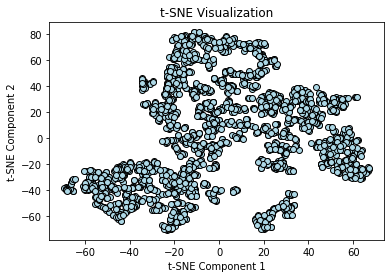

In [ ]:
plt.scatter(low_dim_data[:, 0], low_dim_data[:, 1], c='lightblue', edgecolors='black', marker='o')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()

In [ ]:
vocabulary = np.array(['alcohol', 'aldehyd', 'almond', 'amber', 'anim', 'anis', 'appl',
       'apricot', 'aromat', 'bakeri', 'balsam', 'banana', 'bergamot',
       'berri', 'beverag', 'bitter', 'brown', 'burnt', 'butter',
       'camphor', 'caramel', 'cedar', 'chees', 'chemic', 'cherri',
       'chocol', 'cinnamon', 'citrus', 'clean', 'cocoa', 'coconut',
       'coffe', 'cognac', 'cool', 'cortex', 'coumarin', 'creami',
       'cucumb', 'dairi', 'earthi', 'ether', 'fatti', 'ferment', 'floral',
       'flower', 'fresh', 'fruiti', 'gardenia', 'geranium', 'gerard',
       'grape', 'grassi', 'green', 'herbal', 'honey', 'hyacinth',
       'jasmin', 'juici', 'lacton', 'lavend', 'leaf', 'leather', 'lemon',
       'lilac', 'lili', 'lime', 'meat', 'medicin', 'melon', 'metal',
       'milki', 'mint', 'muguet', 'mushroom', 'musk', 'musti', 'natur',
       'neroli', 'nutti', 'oili', 'orang', 'orri', 'ozon', 'peach',
       'pear', 'phenol', 'pine', 'pineappl', 'plum', 'powderi', 'pungent',
       'raspberri', 'ripe', 'roast', 'rose', 'sharp', 'soapi', 'spice',
       'strawberri', 'sulfur', 'terpen', 'tobacco', 'tropic', 'vanilla',
       'veget', 'vetiv', 'violet', 'warm', 'waxi', 'weedi', 'wine',
       'woodi'])